# Summation Effects

Words, words, words.

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import create_times
from neurodsp.plts import plot_time_series
from neurodsp.utils.download import load_ndsp_data
from neurodsp.spectral import compute_spectrum_welch

from fooof import FOOOF
from fooof.plts import plot_spectra

## Settings

In [2]:
plt_kwargs = {'log_freqs' : True, 'log_powers' : True, 'alpha' : 0.4}

In [3]:
npersegs = [100, 500, 1000, 1500, 2500]
npoints = [100, 250, 500, 1000, 2000, 5000, 10000]

In [4]:
SAVE_FIG = True

## Functions

In [5]:
def compute_across_npersegs(sig, fs, npersegs):
    
    nseg_freqs = []
    nseg_powers = []
    
    for nperseg in npersegs:
        
        freqs, pows = compute_spectrum_welch(sig, fs, nperseg=nperseg)
        
        nseg_freqs.append(freqs)
        nseg_powers.append(pows)
        
    return nseg_freqs, nseg_powers

In [6]:
def compute_across_npoints(sig, fs, npoints):
    
    npoint_freqs = []
    npoint_powers = []
    
    for npoint in npoints:
    
        # Shut off the warning about nperseg, that gets updated to reflect n_points
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, pows = compute_spectrum_welch(sig[0:npoint], fs)
    
        npoint_freqs.append(freqs)
        npoint_powers.append(pows)
        
    return npoint_freqs, npoint_powers

In [7]:
def fit_exponents(values, freqs, powers, label='', fm=FOOOF(), freq_range=None,
                  print_values=True, return_values=False):
        
    exps = []
    for value, freq, power in zip(values, freqs, powers):
        fm.fit(freq, power, freq_range)
        exp = fm.get_params('aperiodic_params', 'exponent')
    
        if print_values:
            print('With {} of {:d} \tfit exponent is \t{:1.2f}'.format(label, value, exp))
            
        exps.append(exp)

    if return_values:
        return exps

## Simulated Data

We'll start with some simulated data, using true 1/f signals.

We can use these simulations to check that there if there is any kind of estimation bias of measuring 1/f when taking different window sizes.

In [8]:
# Settings
n_seconds = 10
fs = 1000
exp = -1.5

In [9]:
sig = sim_powerlaw(n_seconds, fs, exp)
times = create_times(n_seconds, fs)

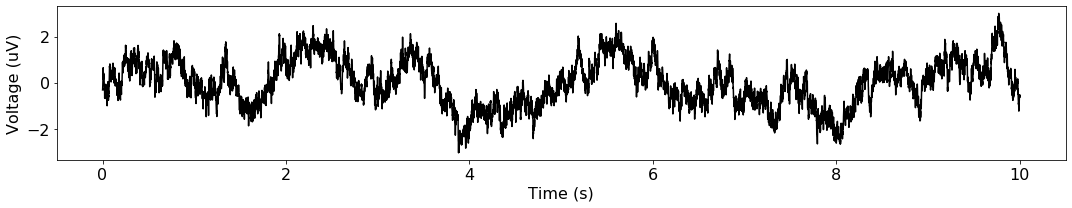

In [10]:
plot_time_series(times, sig)

### Checking Number of Points per Segment

In [11]:
nseg_freqs, nseg_powers = compute_across_npersegs(sig, fs, npersegs)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


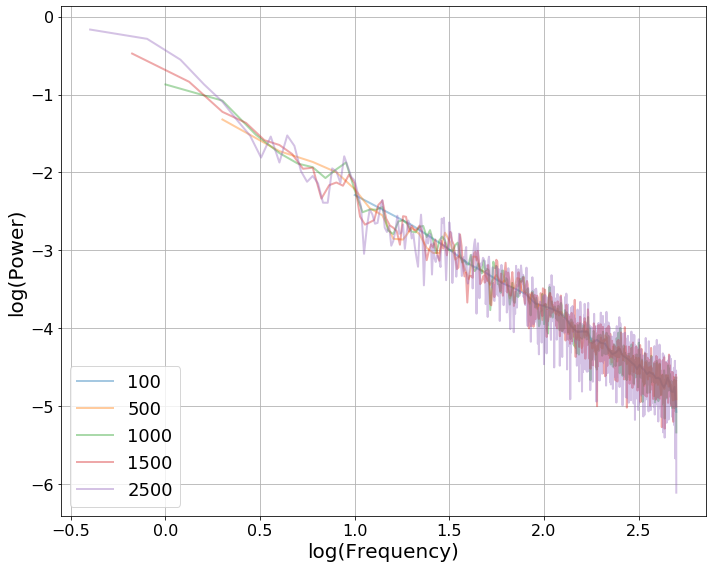

In [12]:
plot_spectra(nseg_freqs, nseg_powers, labels=npersegs, **plt_kwargs)
plt.gca().legend(prop={'size': 18}, loc='lower left')
if SAVE_FIG:
    plt.tight_layout()
    plt.savefig('sims-nperseg.pdf')

In [13]:
# ... 
fm = FOOOF(max_n_peaks = 0, verbose=False)
fit_exponents(npersegs, nseg_freqs, nseg_powers, label='nperseg', fm=fm)

With nperseg of 100 	fit exponent is 	1.52
With nperseg of 500 	fit exponent is 	1.48
With nperseg of 1000 	fit exponent is 	1.51
With nperseg of 1500 	fit exponent is 	1.49
With nperseg of 2500 	fit exponent is 	1.50


### Checking Amount of Data Used

Next, ...

In [14]:
npoint_freqs, npoint_powers = compute_across_npoints(sig, fs, npoints)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


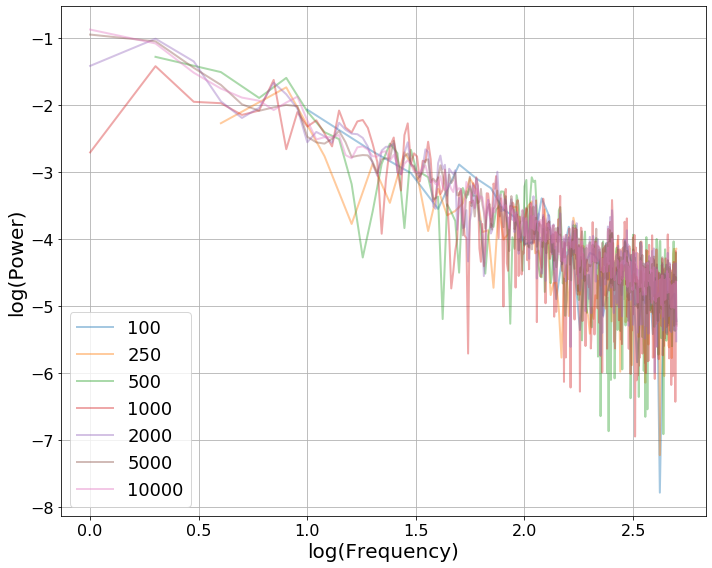

In [15]:
plot_spectra(npoint_freqs, npoint_powers, labels=npoints, **plt_kwargs)
plt.gca().legend(prop={'size': 18}, loc='lower left')
if SAVE_FIG:
    plt.tight_layout()
    plt.savefig('sims-npoints.pdf')

In [16]:
# ... 
fm = FOOOF(max_n_peaks = 0, verbose=False)
fit_exponents(npoints, npoint_freqs, npoint_powers, label='npoints', fm=fm)

With npoints of 100 	fit exponent is 	1.95
With npoints of 250 	fit exponent is 	1.50
With npoints of 500 	fit exponent is 	1.52
With npoints of 1000 	fit exponent is 	1.53
With npoints of 2000 	fit exponent is 	1.56
With npoints of 5000 	fit exponent is 	1.51
With npoints of 10000 	fit exponent is 	1.51


So far, we have used ....

Since, we're using simulated >...

## Real Data: NDSP Data


In [17]:
# ...
sig = load_ndsp_data('sample_data_1.npy', folder='data')

In [18]:
fs = 1000
times = create_times(len(sig)/fs, fs)
print(len(sig))

10000


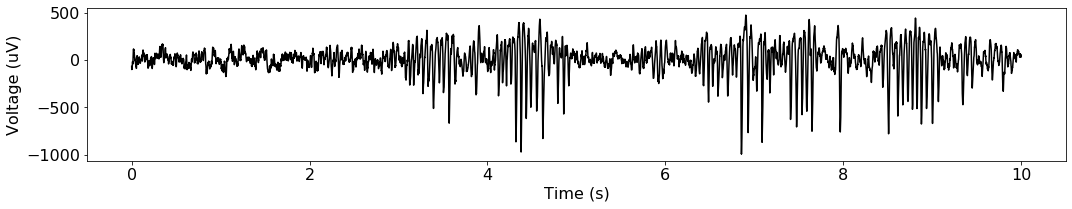

In [19]:
plot_time_series(times, sig)

In [20]:
npoints = [150, 250, 500, 1000, 2000, 5000, 10000]#, 15000, 25000]

In [21]:
npoint_freqs, npoint_powers = compute_across_npoints(sig, fs, npoints)
#npoint_freqs, npoint_powers = compute_across_npersegs(sig, fs, npersegs)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


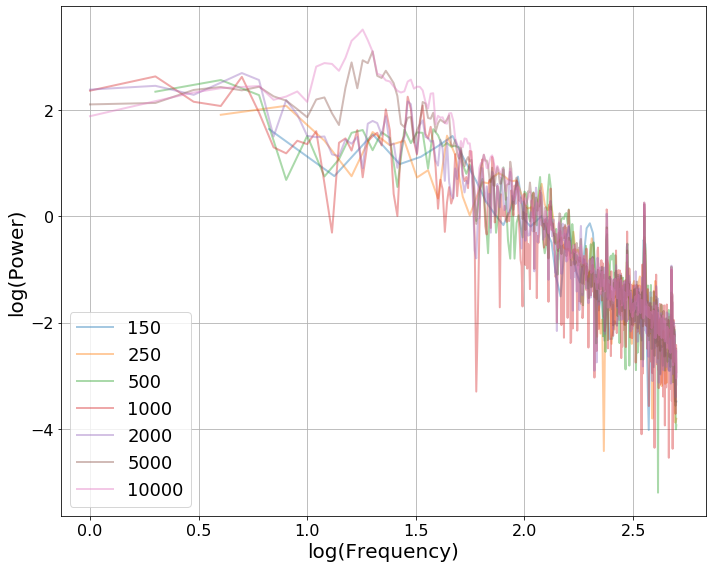

In [22]:
plot_spectra(npoint_freqs, npoint_powers, labels=npoints, **plt_kwargs)
plt.gca().legend(prop={'size': 18}, loc='lower left')
if SAVE_FIG:
    plt.tight_layout()
    plt.savefig('lfp-npoints.pdf')

In [23]:
# ... 
fm = FOOOF(max_n_peaks=6, aperiodic_mode='knee', verbose=False)
freq_range = [5, 150]
exps = fit_exponents(npoints, npoint_freqs, npoint_powers, label='npoints',
                     fm=fm, freq_range=freq_range, return_values=True)

With npoints of 150 	fit exponent is 	5.17
With npoints of 250 	fit exponent is 	1.61
With npoints of 500 	fit exponent is 	2.41
With npoints of 1000 	fit exponent is 	1.95
With npoints of 2000 	fit exponent is 	3.37
With npoints of 5000 	fit exponent is 	3.35
With npoints of 10000 	fit exponent is 	3.85


In [24]:
# Check the correlation between measured exponent, and number of points
spearmanr(npoints, exps)

SpearmanrResult(correlation=0.1785714285714286, pvalue=0.7016579425162729)

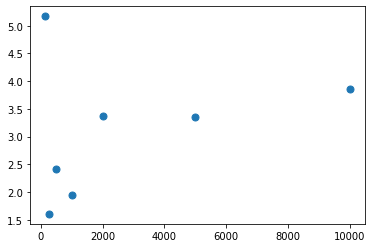

In [25]:
# Check pattern of estimated exponents across npoints
plt.plot(npoints, exps, '.', ms=14)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


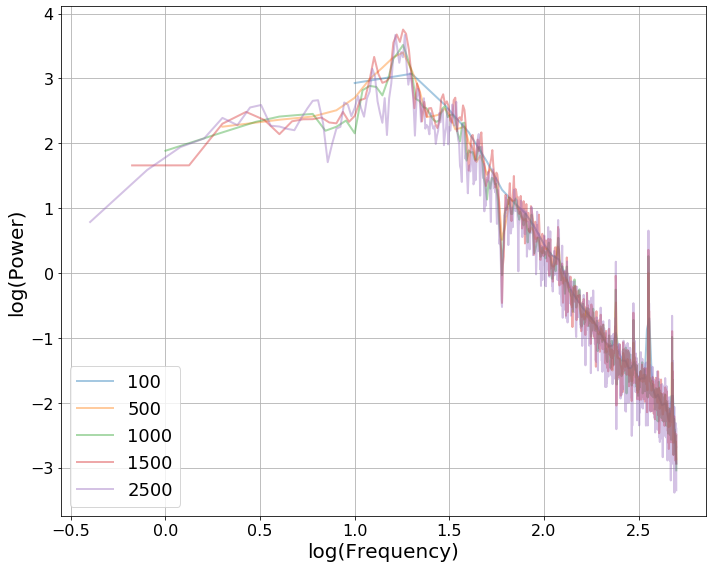

In [26]:
# Check nperseg for LFP data
nseg_freqs, nseg_powers = compute_across_npersegs(sig, fs, npersegs)
plot_spectra(nseg_freqs, nseg_powers, labels=npersegs, **plt_kwargs)
plt.gca().legend(prop={'size': 18}, loc='lower left')
if SAVE_FIG:
    plt.tight_layout()
    plt.savefig('lfp-nperseg.pdf')

## Real Data: EEG Data

In [27]:
# ...
eeg_data = np.load('eeg_data.npy')
fs = 512

In [28]:
print(eeg_data.shape)

(73, 1396224)


In [29]:
ch = 30
eeg_sig = eeg_data[ch, :]

In [30]:
npoints = [150, 250, 500, 1000, 2000, 5000, 10000, 15000, 25000]

In [31]:
npoint_freqs, npoint_powers = compute_across_npoints(eeg_sig, fs, npoints)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


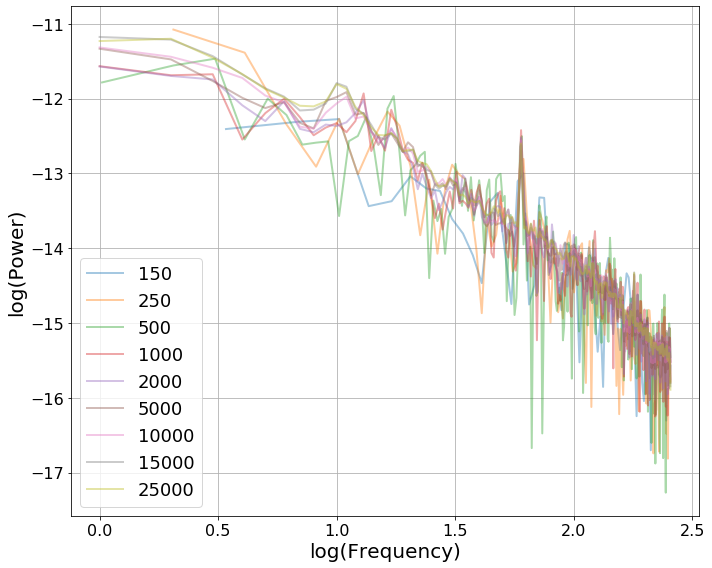

In [32]:
plot_spectra(npoint_freqs, npoint_powers, labels=npoints, **plt_kwargs)
plt.gca().legend(prop={'size': 18}, loc='lower left')
if SAVE_FIG:
    plt.tight_layout()
    plt.savefig('eeg-npoints.pdf')

In [33]:
fm = FOOOF(max_n_peaks=6, aperiodic_mode='fixed', verbose=False)
freq_range=[5, 150]
exps = fit_exponents(npoints, npoint_freqs, npoint_powers, label='npoints',
                     fm=fm, freq_range=freq_range, return_values=True)

With npoints of 150 	fit exponent is 	2.19
With npoints of 250 	fit exponent is 	1.64
With npoints of 500 	fit exponent is 	2.12
With npoints of 1000 	fit exponent is 	1.92
With npoints of 2000 	fit exponent is 	1.92
With npoints of 5000 	fit exponent is 	1.85
With npoints of 10000 	fit exponent is 	1.79
With npoints of 15000 	fit exponent is 	1.90
With npoints of 25000 	fit exponent is 	1.95


In [34]:
# Check the correlation between measured exponent, and number of points
spearmanr(npoints, exps)

SpearmanrResult(correlation=-0.2333333333333333, pvalue=0.5456987782182727)

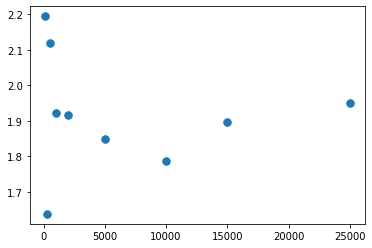

In [35]:
# Check pattern of estimated exponents across npoints
plt.plot(npoints, exps, '.', ms=15)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


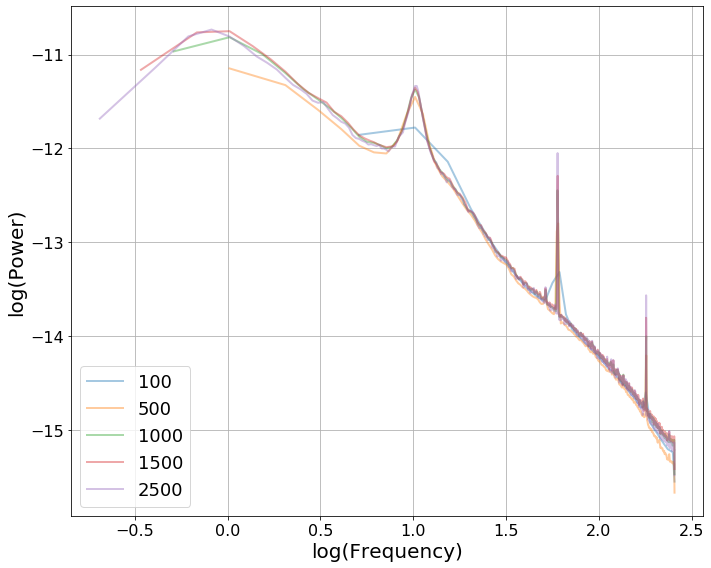

In [36]:
# Check nperseg for EEG data
nseg_freqs, nseg_powers = compute_across_npersegs(eeg_sig, fs, npersegs)
plot_spectra(nseg_freqs, nseg_powers, labels=npersegs, **plt_kwargs)
plt.gca().legend(prop={'size': 18}, loc='lower left')
if SAVE_FIG:
    plt.tight_layout()
    plt.savefig('eeg-nperseg.pdf')